#### libraries and GPU

In [1]:
                                    ####### VISUALIZATION TOOLS #######
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import colormaps as cm
import seaborn as sns
%matplotlib inline
import warnings #ignore the errors for newer version of distplot
warnings.filterwarnings("ignore", category=UserWarning) 

                                    ####### VECTORS AND MATRICES #######

import numpy as np
import pandas as pd

                                    ####### SCIPY #######

from scipy import stats

                                    ####### SCIKIT-LEARN #######

from sklearn.preprocessing import StandardScaler #for Z-score normalization
from sklearn.preprocessing import PolynomialFeatures #to do a polynomial regression

from sklearn.linear_model import LinearRegression #for linear (parameter) regression
from sklearn.linear_model import Ridge #for ridge regression

from sklearn.metrics import mean_squared_error #for MSE error
from sklearn.metrics import r2_score #for the R^2 score on muliple variable regression
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline #to use pipelines

from sklearn.model_selection import train_test_split #train-test splitting
from sklearn.model_selection import cross_val_score #K-fold validation
from sklearn.model_selection import cross_val_predict #K-fold validation
from sklearn.model_selection import GridSearchCV #for GridSearchCV

from sklearn.decomposition import PCA

from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
from sklearn.datasets import load_breast_cancer
cancers = load_breast_cancer()

                                    ####### PYTORCH #######
import torch
from torch import nn #train neural networks
from torch import optim #optimizer
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torchvision.models as models

                                   ####### IMAGES #######
                                   
import os
from PIL import Image, ImageFile
import copy



import operator
import sys

import gymnasium
from gymnasium.wrappers import RecordVideo
import glob, io, base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import random


from collections import namedtuple, deque

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
print(torch.backends.mps.is_available())  # True 
print(torch.backends.mps.is_built())      # True 




mps
True
True


# Download the animal-dataset from Kaggle to local: run one time!

In [2]:
!pip install kaggle

In [3]:
import shutil

#create an hidden directory .kaggle (which is fundamental for using the library kaggle), then move the kaggle.json from the
#folder I created (KAGGLE) to the standard .kaggle
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
kaggle_json_path = os.path.expanduser('~/Desktop/programmazione/KAGGLE/kaggle.json') 
shutil.copy(kaggle_json_path, os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600) #set the correct premission

#download and unzip the dataset we want
!kaggle datasets download ikjotsingh221/animal-dataset --force
!unzip -o animal-dataset.zip -d animal_dataset #the unzipped content is saved in the directory animal_dataset

Dataset URL: https://www.kaggle.com/datasets/ikjotsingh221/animal-dataset
License(s): unknown
  0%|                                               | 0.00/62.3M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 62.3M/62.3M [00:00<00:00, 1.60GB/s]
Archive:  animal-dataset.zip
  inflating: animal_dataset/dataset/Testing/bears/k4 (100).jpeg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (100).jpg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (101).jpeg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (101).jpg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (102).jpeg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (102).jpg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (103).jpeg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (104).jpeg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (105).jpeg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (106).jpeg  
  inflating: animal_dataset/dataset/Testing/bears/k4 (107)

In [38]:
def is_not_truncated(file_path):
    try:
        with Image.open(file_path) as img:
            img.load()
            return True
    except OSError:
        return False
    
def image_checker(folder_path):
    corrupted = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                if not is_not_truncated(path):
                    corrupted.append(path)

    if corrupted:
        print("List of corrupted images:")
        for path in corrupted:
            print(path)
    else:
        print("✅✅✅✅ No corrupted images found ✅✅✅✅")

ImageFile.LOAD_TRUNCATED_IMAGES = False  # Raise error on truncated images
image_checker('animal_dataset')

✅✅✅✅ No corrupted images found ✅✅✅✅


First we look the subfolders, to see what we have to import:

In [53]:
for root, dirs, files in os.walk('animal_dataset'): print(root)

animal_dataset
animal_dataset/dataset
animal_dataset/dataset/Training
animal_dataset/dataset/Training/crows
animal_dataset/dataset/Training/rats
animal_dataset/dataset/Training/bears
animal_dataset/dataset/Training/elephants
animal_dataset/dataset/Testing
animal_dataset/dataset/Testing/crows
animal_dataset/dataset/Testing/rats
animal_dataset/dataset/Testing/bears
animal_dataset/dataset/Testing/elephants
animal_dataset/.checkpoints


# From local to PyTorch

Now we load to Torch tensors, using some standard normalization on the three channels (the images are not black-white); also, we resize the original images to 32x32, to improve training duration:

In [183]:
resize_dim = 256

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((resize_dim, resize_dim)),  # Resize images from 224x224 pixels to 'nxn' pixels
    torchvision.transforms.ToTensor(),           # Convert images to PyTorch tensors
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values with the standard for imagenet
])

train_dataset = torchvision.datasets.ImageFolder('animal_dataset/dataset/Training',
                                     transform=transform,
                                     is_valid_file = is_not_truncated)

val_dataset = torchvision.datasets.ImageFolder('animal_dataset/dataset/Testing', transform=transform, is_valid_file = is_not_truncated)

image_8=train_dataset[8][0]
label_8=torch.tensor(train_dataset[8][1],dtype=torch.int64).unsqueeze(0) #it is [1], the label of the image 8

print(
  'In this database there are m =', len(train_dataset),
  'images of train with D =', image_8.shape[1], 'x', image_8.shape[2], '=', image_8.shape[1] * image_8.shape[2],
  'features. The target is', label_8.shape[0], 'dimensional.'
)
print('The test set has m =',len(val_dataset),'data.')
print('The number of channel is',image_8.shape[0],'.\n')




batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,drop_last = True)

In this database there are m = 1238 images of train with D = 256 x 256 = 65536 features. The target is 1 dimensional.
The test set has m = 326 data.
The number of channel is 3 .



The labels are well distribuited:

In [184]:
train_dataset[0][1]#--> 0: crows
train_dataset[395][1] #--> 1: rats
train_dataset[626][1] #--> 2: bears
train_dataset[993][1] #--> 3: elephants

lst=[]
for X_train,y_train in train_dataset:
    lst.append(y_train)

lst=pd.DataFrame(lst,columns=['label'])
print(lst['label'].value_counts())
    

label
0    395
2    367
3    245
1    231
Name: count, dtype: int64


Now we see some images:

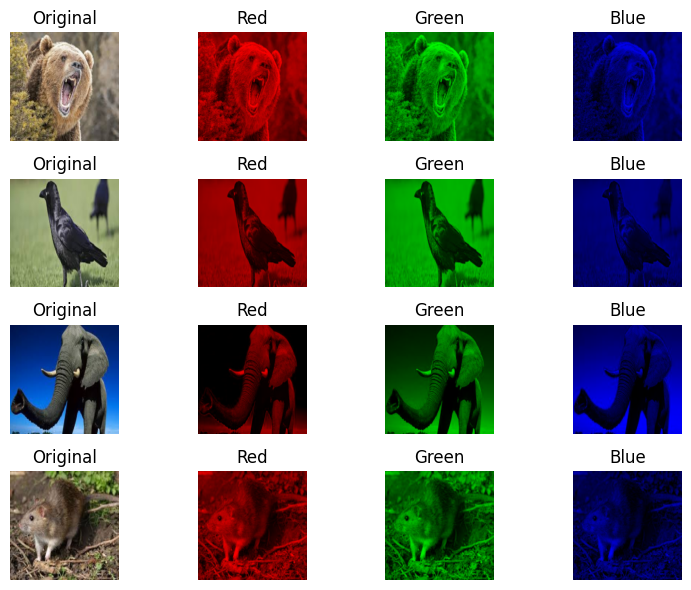

In [187]:
fig, axes = plt.subplots(4, 4, figsize=(8, 6))
lst=[0, 395, 626, 993] #indices of the images we want to visualize

for i in range(4):
    img_tensor, _ = train_dataset[lst[i]]  # img_tensor: shape [3, 32, 32]
    img = img_tensor.swapaxes(0,1).swapaxes(1,2)*torch.tensor([0.229, 0.224, 0.225])+torch.tensor([0.485, 0.456, 0.406]) 

    r = copy.deepcopy(img)
    r[:, :, 1] = r[:, :, 2] = 0

    g = copy.deepcopy(img)
    g[:, :, 0] = g[:, :, 2] = 0

    b = copy.deepcopy(img)
    b[:, :, 0] = b[:, :, 1] = 0

    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Original")

    axes[i, 1].imshow(r)
    axes[i, 1].set_title("Red")

    axes[i, 2].imshow(g)
    axes[i, 2].set_title("Green")

    axes[i, 3].imshow(b)
    axes[i, 3].set_title("Blue")

for ax in axes.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()
plt.close()

# CNN architecture

4 output neurons, for 4 classes:

In [173]:
n = resize_dim  # n = 32, dimensione dell'immagine in input

class my_net(nn.Module):
     
    def __init__(self):
        super().__init__()
        ks_conv = 5
        s_conv = 1
        p_conv = 1
        ks_pool = 2
        s_pool = 2
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=ks_conv, stride=s_conv, padding=p_conv)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=ks_conv, stride=s_conv, padding=p_conv)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=ks_conv, stride=s_conv, padding=p_conv)
        self.bn3 = nn.BatchNorm2d(16)

        self.activation = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=ks_pool, stride=s_pool)
        self.dropout = nn.Dropout(p=0.2)
        
        self.flatten = nn.Flatten(1,3)
        self.fc1 = nn.Linear(((((n-2)//2-2)//2-2)//2)**2 *16, 16)
        self.fc2 = nn.Linear(16, 4) #4 classes: crows, rats, bears, elephants

        # do not put the softmax!

    def forward(self, x):
        # Input shape: (batch_size, 3, n, n)
        x = self.activation(self.bn1(self.conv1(x)))  # -> (batch_size, 16, n-2, n-2)
        x = self.pooling(x)  # -> (batch_size,16, (n-2)//2, (n-2)//2)
        x = self.dropout(x)

        x = self.activation(self.bn2(self.conv2(x)))  # -> (batch_size, 16, (n-2)//2-2, (n-2)//2-2)
        x = self.pooling(x) # -> (batch_size, 16, ((n-2)//2-2)//2, ((n-2)//2-2)//2)
        x = self.dropout(x)

        x = self.activation(self.bn3(self.conv3(x)))  # -> (batch_size, 16 , ((n-2)//2-2)//2-2, ((n-2)//2-2)//2-2)
        x = self.pooling(x) # -> (batch_size, 16, (((n-2)//2-2)//2-2)//2, (((n-2)//2-2)//2-2)//2)
        x = self.dropout(x)

        x = self.flatten(x)  # -> (batch_size, ((((n-2)//2-2)//2-2)//2)**2 *16)

        x = self.activation(self.fc1(x))  # -> (batch_size, 16)
        x = self.dropout(x)

        x = self.fc2(x)  # -> (batch_size, 4)
        return x

# Inizializzazione del modello
model = my_net().to(device)


# Metric of performance : accuracy

Taken equal from the MNIST classification (10 cifres):

In [174]:
def accuracy_of_model(model, train_loader, test_loader):
    correct_train, correct_test = 0., 0.
    model.eval()
    with torch.no_grad():
        for x_train, y_train in train_loader:
            x_train = x_train.to(device)  # Move input to the device
            y_train = y_train.to(device)  # Move target to the device
            model.to(device)  # Ensure the model is on the correct device
            out_vector = torch.softmax(model(x_train), dim=1) #this is the index which corresponds to the maximum value in the output vector, and it is already the assigned class
            y_pred = torch.argmax(out_vector, dim=1) 
            correct_train += (y_pred.squeeze() == y_train.squeeze()).sum().item()
        
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)  # Move input to the device
            y_test = y_test.to(device)  # Move target to the device
            model.to(device)  # Ensure the model is on the correct device
            out_vector = torch.softmax(model(x_test), dim=1)  #this is the index which corresponds to the maximum value in the output vector, and it is already the assigned class
            y_pred = torch.argmax(out_vector, dim=1)
            correct_test += (y_pred.squeeze() == y_test.squeeze()).sum().item() 
    
    acc_train = correct_train / len(train_loader.dataset) * 100
    acc_test = correct_test / len(test_loader.dataset) * 100
    return acc_train, acc_test

accuracy_of_model(model, train_loader, val_loader)

(18.174474959612276, 22.085889570552148)

# Early stopping

This code is taken from https://github.com/Bjarten/early-stopping-pytorch.

In this EarlyStopping class, the code checks that a particular metric is non deteriorating too much (so this class works very well only for metrics that we want to **minimize**, as a loss, but not for an accuracy for example!). When everything is going in the right direction, we save the parameters of the model (**model.state_dict()**) as checkpoints in a particular path by using **torch.save(model.state_dict(), self.path)**. In particular **torch.save(obj, f)** isa function in PyTorch used to serialize and save an objectì (obj) to a file (f) using Python's pickle serialization. When obj is a model's state dictionary (model.state_dict()), torch.save() serializes the dictionary and saves it to the specified file path (f).

In [175]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement: after 'patient number of epochs' without improvement, training will stop
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement: if the validation metric does not improve by at least 'delta', it is not considered an improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path) 

  def __call__(self, val_metric, model):
    if self.best_score is None: #
      self.best_score = val_metric
      self.save_checkpoint(model)

    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0

  

# Train the model 

The command **model.load_state_dict(torch.load('animal_dataset/.checkpoints/model_checkpoint.pt'))**, which must be put out of the training (and evaluation) cycle, fixes the parameters of the model to their best value. If this command is not present, after the cycle the parameters are the ones of the last epoch, but not the ones at which the early stopping has appeared!

In [176]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

EPOCHS = 50
learning_rate = 0.01

model = my_net().to(device) #we create the model
loss_function = nn.CrossEntropyLoss() # non-binary cross-entropy estimator, we will minimize this during the (stochastic) gradient descent
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
early_stopping = EarlyStopping(patience=4, delta=0, verbose=True, path='animal_dataset/.checkpoints/model_checkpoint_{learning_rate}.pt')

for epoch in range(EPOCHS):
  model.train() # Set the model to training mode
  train_loss = 0.0
    
  for x_train, y_train in train_loader: #for each epoch, we do the backpropagation etc for each batch
    x_train = x_train.to(device)  # Move input to the device
    y_train = y_train.to(device)  # Move target to the device
    yhat = model(x_train) #the model returns a tensor of shape (batch_size,1), we squeeze it to have a tensor of shape (batch_size,)
    loss = loss_function(yhat, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss
  
  model.eval()
  with torch.no_grad():
      val_loss = 0.0 
      for x_val, y_val in val_loader: 
          x_val = x_val.to(device)  # Move input to the device
          y_val = y_val.to(device)  
          out_val = model(x_val) 
          loss = loss_function(out_val, y_val).item()
          val_loss += loss


  train_loss /= len(train_loader)   # we divide by the number of batches
  val_loss /= len(val_loader)  
  early_stopping(val_metric=val_loss, model=model) # Check if we should stop training early
  train_losses.append(train_loss.detach().cpu())
  val_losses.append(val_loss)

  train_acc, val_acc = accuracy_of_model(model, train_loader, val_loader)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print("At epoch", epoch, f": Train accuracy: {float(train_acc):.2f}%,  Validation accuracy: {float(val_acc):.2f}%,")
  print("At epoch", epoch, f": Train loss: {train_losses[-1].item():.2f},  Validation loss: {val_losses[-1]:.2f},")

  if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
  
  
  
model.load_state_dict(torch.load('animal_dataset/.checkpoints/model_checkpoint_{learning_rate}.pt')) 

print(f"The best accuracy on the train set is {train_accuracies[-1]:.2f}%")
print(f"The best accuracy on the val set is {val_accuracies[-1]:.2f}%")
print('The lowest loss on the train set is',train_losses[-1].item())
print('The lowest loss on the val set is',val_losses[-1])


At epoch 0 : Train accuracy: 51.86%,  Validation accuracy: 56.75%,
At epoch 0 : Train loss: 1.26,  Validation loss: 0.99,
At epoch 1 : Train accuracy: 54.36%,  Validation accuracy: 57.67%,
At epoch 1 : Train loss: 1.08,  Validation loss: 0.95,
At epoch 2 : Train accuracy: 59.05%,  Validation accuracy: 64.42%,
At epoch 2 : Train loss: 1.01,  Validation loss: 0.89,
At epoch 3 : Train accuracy: 63.41%,  Validation accuracy: 65.03%,
At epoch 3 : Train loss: 0.98,  Validation loss: 0.86,
At epoch 4 : Train accuracy: 64.46%,  Validation accuracy: 71.47%,
At epoch 4 : Train loss: 0.91,  Validation loss: 0.67,
At epoch 5 : Train accuracy: 68.58%,  Validation accuracy: 74.23%,
At epoch 5 : Train loss: 0.85,  Validation loss: 0.57,
Epochs without improvement: 1
At epoch 6 : Train accuracy: 69.55%,  Validation accuracy: 74.23%,
At epoch 6 : Train loss: 0.83,  Validation loss: 0.65,
Epochs without improvement: 2
At epoch 7 : Train accuracy: 69.06%,  Validation accuracy: 73.93%,
At epoch 7 : Train 

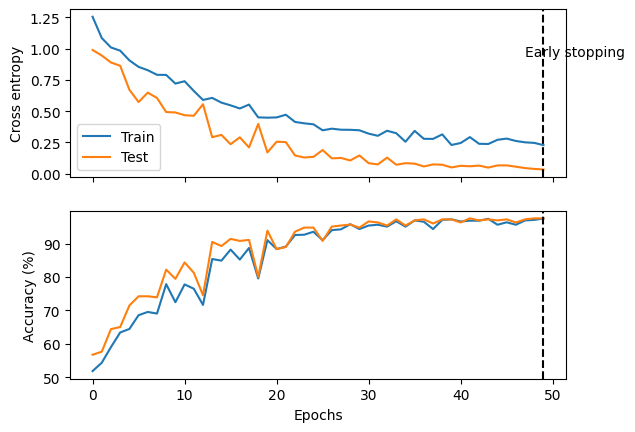

In [177]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
ax[0].plot(train_losses, label = "Train")
ax[0].plot(val_losses, label = "Test")
ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)
ax[0].vlines(np.argmin(val_losses), ymin=ymin, ymax=ymax, color = 'black', linestyle = '--')
ax[0].text(x = np.argmin(val_losses) - 2, y = (ymax+ymin)/2 + 0.3, s = "Early stopping")
ax[0].legend()
ax[0].set_ylabel("Cross entropy")
ax[1].plot(train_accuracies, label = "Train")
ax[1].plot(val_accuracies, label = "Test")
ymin, ymax = ax[1].get_ylim()
ax[1].set_ylim(ymin, ymax)
ax[1].vlines(np.argmin(val_losses), ymin=ymin, ymax=ymax, color = 'black', linestyle = '--', )
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
plt.show()
plt.close()

# Parameter fine tuning

We want now to evaluate the model performances for different values of the hyperparameters (only le learning rate in this case.) We repeat everything as before basically, but we have to save the configurations of parameters for each value of learning rate, so that at the end we can use **model.load_state_dict(torch.load('animal_dataset/.checkpoints/model_checkpoint_{learning_rate}.pt'))** to use the best model later on!

In [140]:
loss_function = nn.CrossEntropyLoss()

def par_tuning(lrs,EPOCHS):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    results = []
    for learning_rate in lrs:
        print("Learning rate:", learning_rate)
        model=my_net().to(device) 
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        early_stopping = EarlyStopping(patience=4, verbose=False, path=f'animal_dataset/.checkpoints/model_checkpoint_{learning_rate}.pt')
        for epoch in range(EPOCHS):
            model.train() # Set the model to training mode
            train_loss = 0.0
    
            for x_train, y_train in train_loader: #for each epoch, we do the backpropagation etc for each batch
                x_train = x_train.to(device)  # Move input to the device
                y_train = y_train.to(device)  # Move target to the device
                yhat = model(x_train) #the model returns a tensor of shape (batch_size,1), we squeeze it to have a tensor of shape (batch_size,)
                loss = loss_function(yhat, y_train)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss
  
            model.eval()
            with torch.no_grad():
                val_loss = 0.0 
                for x_val, y_val in val_loader: 
                    x_val = x_val.to(device)  # Move input to the device
                    y_val = y_val.to(device)  
                    out_val = model(x_val) 
                    loss = loss_function(out_val, y_val).item()
                    val_loss += loss


            train_loss /= len(train_loader)   # we divide by the number of batches
            val_loss /= len(val_loader)  
            early_stopping(val_metric=val_loss, model=model) # Check if we should stop training early
            train_losses.append(train_loss.detach().cpu())
            val_losses.append(val_loss)

            train_acc, val_acc = accuracy_of_model(model, train_loader, val_loader)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)


            if early_stopping.early_stop:
                    print("Early stopping triggered.")
                    break
  
  
  
        model.load_state_dict(torch.load(f'animal_dataset/.checkpoints/model_checkpoint_{learning_rate}.pt'))
 

        print(f"The best accuracy on the train set is {train_accuracies[-1]:.2f}%")
        print(f"The best accuracy on the val set is {val_accuracies[-1]:.2f}%")
        print('The lowest loss on the train set is',train_losses[-1].item())
        print('The lowest loss on the val set is',val_losses[-1])
            
        results.append([train_loss.item(), val_loss, train_acc, val_acc])
        

    return results

lrs = [0.01, 0.02]
results = par_tuning(lrs, 1)



Learning rate: 0.01
The best accuracy on the train set is 51.21%
The best accuracy on the val set is 52.76%
The lowest loss on the train set is 1.2586252689361572
The lowest loss on the val set is 1.0205688238143922
Learning rate: 0.02
The best accuracy on the train set is 48.22%
The best accuracy on the val set is 51.23%
The lowest loss on the train set is 1.2656301259994507
The lowest loss on the val set is 1.1529130816459656


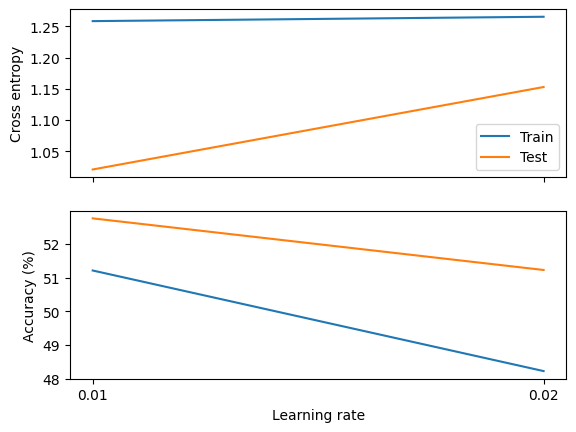

In [142]:
results = np.array(results).T
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
ax[0].plot(lrs, results[0], label = "Train")
ax[0].plot(lrs, results[1], label = "Test")
ax[0].legend()
ax[0].set_ylabel("Cross entropy")
ax[1].plot(lrs, results[2], label = "Train")
ax[1].plot(lrs, results[3], label = "Test")
ax[1].set_xlabel("Learning rate")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xticks(lrs)
plt.show()
plt.close()

Now we can load the best model:

In [143]:
best_lr = lrs[np.argmin(results[1])]
model.load_state_dict(torch.load(f'animal_dataset/.checkpoints/model_checkpoint_{best_lr}.pt'))

<All keys matched successfully>

# Model interpretation

## Confusion matrix

Useful to see which classes are well predicted, and which are not:

In [178]:
model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for X_val, y_val in val_loader:
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    with torch.no_grad():
        out = model(X_val)
        _, y_hat = torch.max(out, 1)

    all_y.extend(y_val.cpu().numpy())
    all_predictions.extend(y_hat.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.01 0.   0.99 0.  ]
 [0.   0.   0.01 0.99]]


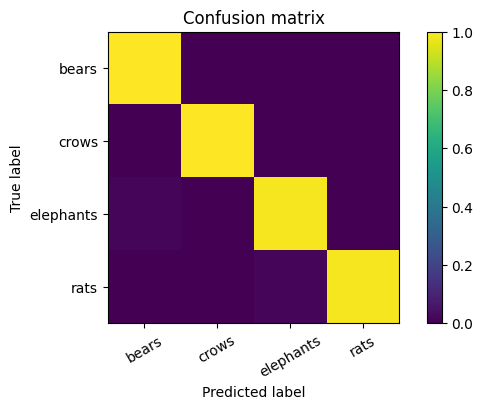

In [179]:
labels =val_dataset.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=30)
plt.yticks(tick_marks, labels)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

## Saliency map

Another tool we can use are **saliency maps**, that provide visual explanations of the model's decision-making process by highlighting the regions of the input image that are most influential in predicting a particular class:

$(SM)_{ijk} = \dfrac{\partial y_{predicted}}{\partial x_{ijk}} $

$ i \in \{1,\dots,n_{\text{channels}}\}$

$ j \in \{1,\dots, W_{\text{idth}}\}$

$ k \in \{1,\dots, H_{\text{eight}}\}$

In [180]:
def generate_saliency_map(model, image):

    model.eval()

    saliency_map = []

    for i in range(image.size(0)):

      x = copy.copy(image[i:i+1])  # we create a copy of the image
      x = x.to(device)
      x.requires_grad = True

      output = model(x).squeeze()

      _, target_class = torch.max(output, -1) # we get the predict class (similar to argmax)

      model.zero_grad()
      output[target_class].backward()

      gradients = x.grad

      map, _ = torch.max(gradients.abs().squeeze(), dim=0) # we get the maximum across channels

      saliency_map.append(map.cpu().detach().numpy())
      saliency_map[i] = (saliency_map[i]- saliency_map[i].min())/(saliency_map[i].max() - saliency_map[i].min())  # we scale saliency map in range [0,1]
      x.requires_grad = False

    return np.array(saliency_map)

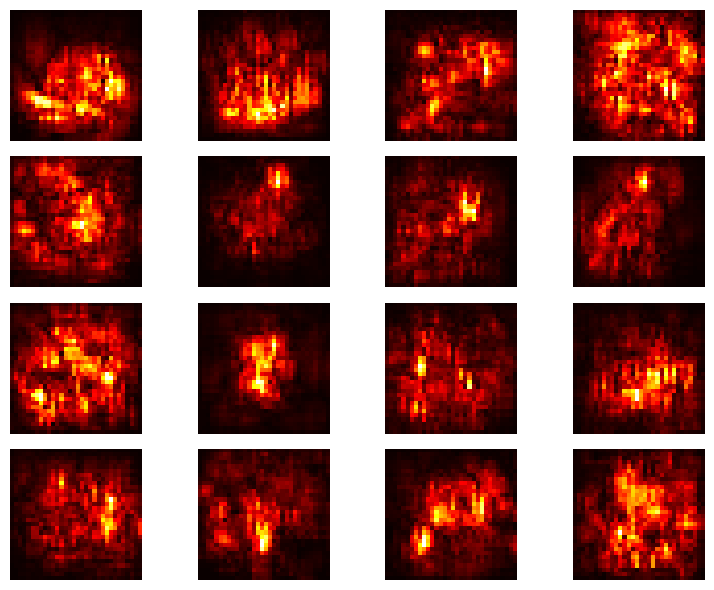

In [181]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
saliency_map = generate_saliency_map(model, example_data)
num_rows = 4
num_cols = 4

colormap = cm["hot"] #select a cm=colormap

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j]) # Apply colormap to saliency map

    axes[i, j].imshow(transforms.ToPILImage()(sm))

    axes[i,j].axis('off')

plt.tight_layout()
plt.show()
plt.close()

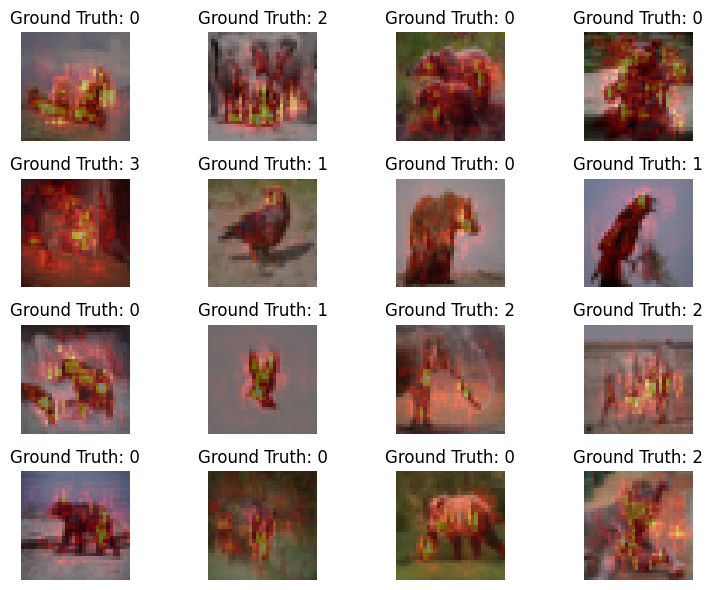

In [182]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j])[:, :, :3]  # Apply colormap to saliency map

    axes[i, j].imshow(Image.blend(Image.fromarray(img), transforms.ToPILImage()(sm), alpha = 0.4))


    axes[i, j].set_title("Ground Truth: {}".format(example_targets[4*i + j]))

    axes[i,j].axis('off')

plt.tight_layout()
plt.show()